In [1]:
import math
import argparse
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain,combinations
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
import ast
import seaborn as sns
from tqdm import tqdm


In [2]:
from Nash import find_nash_equilibria_v2

### HuGaDB 

In [3]:
train_files_pattern = "metadata/train_{i:02d}.csv" # Adjust the path as needed
test_files_pattern = "metadata/test_{i:02d}.csv" # Adjust the path as needed

### Creating Global Train set and Test set

In [4]:
# Load training and testing datasets
df_train_global = pd.concat([pd.read_csv(train_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
X_train_global = df_train_global.drop('act', axis=1)
y_train_global = df_train_global['act']

df_test_global = pd.concat([pd.read_csv(test_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
X_test_global = df_test_global.drop('act', axis=1)
y_test_global = df_test_global['act']

# Encode labels
label_encoder = LabelEncoder()
y_train_global = label_encoder.fit_transform(y_train_global)
y_test_global = label_encoder.transform(y_test_global)

# Scale features
scaler = StandardScaler()
X_train_global_scaled = scaler.fit_transform(X_train_global)
X_test_global_scaled = scaler.transform(X_test_global)


#### Centrelized Training

  0%|          | 0/1 [00:00<?, ?it/s]


Confusion Matrix for Trial 1:
[[11465   221     0     1    51     3   780]
 [  175 11728     0     1    68     2   782]
 [    1     0  7552    21     0    20     1]
 [    0     0    46  1862    26     2     0]
 [   24    28     3    64 26401    52    98]
 [    1     7    70     1   124  2158     1]
 [ 1051   846     0     1   105     0 36458]]


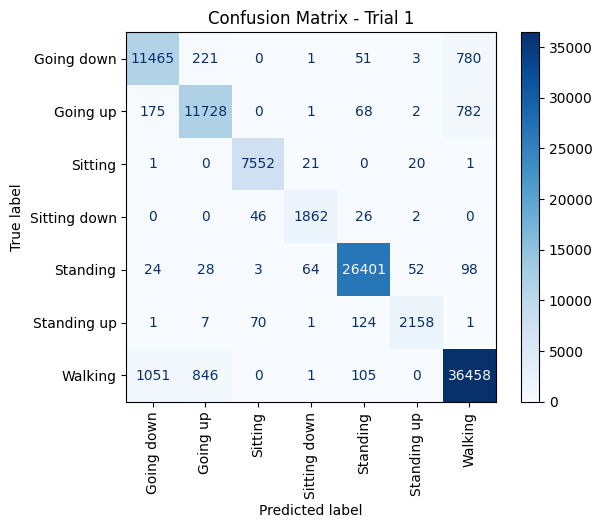

100%|██████████| 1/1 [00:11<00:00, 11.52s/it]

Trial 1/1 - Global test accuracy: 0.9542819718282324


In [6]:
# Parameters
n_trials = 1
n_trees = 10
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

results_global = []


for trial in tqdm(range(n_trials)):
    

    model = RandomForestClassifier(n_estimators=n_trees, random_state=42 + trial)
    model.fit(X_train_global, y_train_global)
    

    y_pred = model.predict(X_test_global)
    acc_test = accuracy_score(y_test_global, y_pred)
    

    cm = confusion_matrix(y_test_global, y_pred)
    print(f"\nConfusion Matrix for Trial {trial + 1}:")
    print(cm)
    

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - Trial {trial + 1}")
    plt.show()
    

    results_global.append(acc_test)
    
    print(f"Trial {trial + 1}/{n_trials} - Global test accuracy: {acc_test}")


df_global = pd.DataFrame(results_global, columns=["accuracy"])
df_global.to_csv("global.csv", index=False)


#### FL

In [7]:
# Define the DecisionTree class
class DecisionTree:
    def __init__(self, max_depth=None, random_state=None):
        self.max_depth = max_depth
        self.tree_ = None
        self.random_state = random_state

    def fit(self, X, y):
        self.tree_ = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
        self.tree_.fit(X, y)

    def predict(self, X):
        return self.tree_.predict(X)

# Define the FederatedForest class
class FederatedForest:
    def __init__(self):
        self.models = []

    def add_model(self, model):
        self.models.append(model)

    def predict(self, X):
        predictions = [model.predict(X) for model in self.models]
        predictions = np.array(predictions).T
        y = [np.bincount(row).argmax() for row in predictions]
        return np.array(y)
    

In [9]:
# Parameters
max_depth = 10
n_clients = 10 
n_trials = 1
random_seed = 42

results = []


for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")

    np.random.seed(random_seed + trial)

    # Train models for the 10 clients
    client_models = []
    client_local_accuracies = []
    client_global_accuracies = []
    for i in range(n_clients):
        df_train_i = pd.read_csv(f"metadata/train_{i+1:02d}.csv").dropna(subset=['act'])
        X_train = df_train_i.drop('act', axis=1)
        y_train = label_encoder.transform(df_train_i['act'])

        model = DecisionTree(max_depth=max_depth, random_state=random_seed + trial)
        model.fit(X_train, y_train)
        client_models.append(model)

        # Test locally
        df_test_i = pd.read_csv(f"metadata/test_{i+1:02d}.csv").dropna(subset=['act'])
        X_test = df_test_i.drop('act', axis=1)
        y_test = label_encoder.transform(df_test_i['act'])

        # Evaluate globally
        y_pred_global = model.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)
        client_global_accuracies.append(acc_global)

    # Evaluate all combinations
    n_combinations = 2 ** n_clients
    for i in range(1, n_combinations):
        bin_str = format(i, f'0{n_clients}b')
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices]

        if not included_models:
            continue

        # Aggregate models
        forest = FederatedForest()
        for model in included_models:
            forest.add_model(model)

        # Global accuracy
        y_pred_global = forest.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)

        # Prepare the result row
        row = {
            'Trial': trial + 1,
            'Combination': bin_str,
            'Clients': [j + 1 for j in client_indices],
            'Global Accuracy': acc_global
        }

        for j in range(n_clients):
            row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]  # Accuracy on global test set
        results.append(row)

df_results = pd.DataFrame(results)
df_results.to_csv("HuGa_results_with_FedFor.csv", index=False)


Trial 1/1


In [10]:
df_results = pd.read_csv("HuGa_results_with_FedFor.csv")

In [11]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(5)

,Trial,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
988,1,1111011101,"[1, 3, 4, 5, 7, 8, 9, 10]",0.883882,0.59584,0.518314,0.634129,0.67711,0.724177,0.658733,0.733238,0.774655,0.733981,0.663258
1020,1,1111111101,"[1, 3, 4, 5, 6, 7, 8, 9, 10]",0.882611,0.59584,0.518314,0.634129,0.67711,0.724177,0.658733,0.733238,0.774655,0.733981,0.663258
508,1,111111101,"[1, 3, 4, 5, 6, 7, 8, 9]",0.881956,0.59584,0.518314,0.634129,0.67711,0.724177,0.658733,0.733238,0.774655,0.733981,0.663258
956,1,1110111101,"[1, 3, 4, 5, 6, 8, 9, 10]",0.881604,0.59584,0.518314,0.634129,0.67711,0.724177,0.658733,0.733238,0.774655,0.733981,0.663258
1019,1,1111111100,"[3, 4, 5, 6, 7, 8, 9, 10]",0.881057,0.59584,0.518314,0.634129,0.67711,0.724177,0.658733,0.733238,0.774655,0.733981,0.663258


In [12]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Trial,Clients,Global Accuracy
0,0000000001,1,[1],0.595840
1,0000000010,1,[2],0.518314
2,0000000100,1,[3],0.634129
3,0000100000,1,[6],0.658733
4,1000000000,1,[10],0.663258
5,1111111111,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.880920


### SpamBase Dataset

In [15]:
file_path = '.../spambase/spambase.data'  # Adjust the path as needed
df = pd.read_csv(file_path, header=None)

### Preprocessing

In [16]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Centrelized

  0%|          | 0/1 [00:00<?, ?it/s]


Confusion Matrix for Trial 1:
[[521  10]
 [ 45 345]]


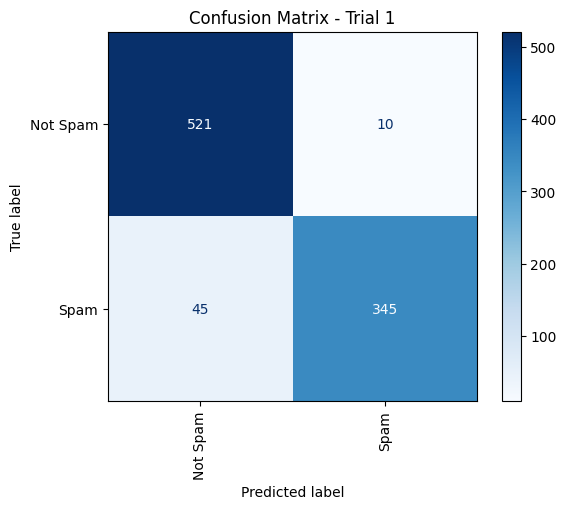

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

Trial 1/1 - Global test accuracy: 0.9402823018458197


In [18]:
# Parameters
n_trials = 1  # Number of trials
n_trees = 10  # Number of trees in the Random Forest
random.seed(random_seed)
np.random.seed(random_seed)

results_global = []

# Training and evaluation loop
for trial in tqdm(range(n_trials)):
    
    # Initialize and train Random Forest
    model = RandomForestClassifier(n_estimators=n_trees, random_state=42 + trial)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for Trial {trial + 1}:")
    print(cm)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Spam", "Spam"])
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - Trial {trial + 1}")
    plt.show()
    
    # Append the accuracy to results
    results_global.append(acc_test)
    print(f"Trial {trial + 1}/{n_trials} - Global test accuracy: {acc_test}")


### FL

In [19]:
def split_data_equal(X: np.ndarray, y: np.ndarray, n_clients: int, shuffle: bool=False):

  if shuffle:
    idx = np.random.permutation(X.shape[0])
    X = X[idx]
    y = y[idx]

  n_entries_per_client = X.shape[0] // n_clients
  partitions = []
  for i in range(n_clients):
    start = i*n_entries_per_client
    end = (i+1)*n_entries_per_client
    X_i = X[start:end]
    y_i = y[start:end]
    partitions.append((X_i, y_i))
  partitions[-1] = (X[start:], y[start:])

  return partitions

# Split data among clients
partitions = split_data_equal(X_train, y_train, n_clients=n_clients, shuffle=True)

In [20]:
# Parameters
max_depth = 10
n_clients = 10
n_trials = 1
random_seed = 42

results = []


# Federated Learning Simulation
for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")

    np.random.seed(random_seed + trial)

    # Train models for the clients
    client_models = []
    client_local_accuracies = []
    client_global_accuracies = []

    for i, (X_i, y_i) in enumerate(partitions):
        # Train a DecisionTree model for the client
        model = DecisionTree(max_depth=max_depth, random_state=random_seed + trial)
        model.fit(X_i, y_i)
        client_models.append(model)

        # Local accuracy on client data
        acc_local = accuracy_score(y_i, model.predict(X_i))
        client_local_accuracies.append(acc_local)

        # Global accuracy on the test set
        acc_global = accuracy_score(y_test, model.predict(X_test))
        client_global_accuracies.append(acc_global)

    # Evaluate all combinations of clients
    n_combinations = 2 ** n_clients
    for i in tqdm(range(1, n_combinations)):
        bin_str = format(i, f'0{n_clients}b')
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices]

        if not included_models:
            continue

        # Aggregate models
        forest = FederatedForest()
        for model in included_models:
            forest.add_model(model)

        # Global accuracy for the aggregated model
        y_pred_global = forest.predict(X_test)
        acc_global = accuracy_score(y_test, y_pred_global)

        # Prepare the result row
        row = {
            'Trial': trial + 1,
            'Combination': bin_str,
            'Clients': [client + 1 for client in client_indices],
            'Global Accuracy': acc_global
        }

        for j in range(n_clients):
            row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]

        results.append(row)

# Save results to CSV
df_results = pd.DataFrame(results)
df_results.to_csv("FedFor Spambase.csv", index=False)


Trial 1/1


100%|██████████| 1023/1023 [00:00<00:00, 1054.56it/s]


In [21]:
df_results = pd.read_csv("FedFor Spambase.csv")

In [22]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(5)

,Trial,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
924,1,1110011101,"[1, 3, 4, 5, 8, 9, 10]",0.921824,0.872964,0.856678,0.868621,0.85342,0.862106,0.862106,0.852334,0.87405,0.864278,0.858849
780,1,1100001101,"[1, 3, 4, 9, 10]",0.921824,0.872964,0.856678,0.868621,0.85342,0.862106,0.862106,0.852334,0.87405,0.864278,0.858849
907,1,1110001100,"[3, 4, 8, 9, 10]",0.920738,0.872964,0.856678,0.868621,0.85342,0.862106,0.862106,0.852334,0.87405,0.864278,0.858849
796,1,1100011101,"[1, 3, 4, 5, 9, 10]",0.920738,0.872964,0.856678,0.868621,0.85342,0.862106,0.862106,0.852334,0.87405,0.864278,0.858849
908,1,1110001101,"[1, 3, 4, 8, 9, 10]",0.919653,0.872964,0.856678,0.868621,0.85342,0.862106,0.862106,0.852334,0.87405,0.864278,0.858849


In [23]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Trial,Clients,Global Accuracy
0,0001000000,1,[7],0.852334
1,1111111111,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.910966
